Deep Neural Network (DNN) - MNIST Example
=========================================
Deep Neural Network (DNN) with Tensor Flow **(low level)**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import deepmods.notebook as ooo
import logging

ooo.init(id='14.2.0', hide_warning=True, save_figs=True)



Deepmod by pjluc 2019
  Version          : 0.4
  Run time         : Monday 16 September 2019, 11:11:31
  Run directory    : ./run/lab-14.2.0
  Save figs        : True
  Matplotlib style : deepmods/talk.mplstyle
  Hide warning     : True

TensorFlow version :  1.14.0
Keras version      :  2.2.4-tf

Init done.


In [2]:

# -------------------------------------------------------------
# show_predictions
# -------------------------------------------------------------
#
def show_predictions(X,y,L,S,y_pred,indices):
    """
    Show some predictions
    args:
        X: inputs images
        y: real classes
        L: logits
        S: softmax
        y_pred: predicted classes
        n: number of x to show
    returns: 
        nothing
    """
    for i in indices:
        # ---- Show x[i]
        print('\nX[{}]'.format(i))   
        # ---- Show prediction
        print('   Output        :', end='')
        print('  '.join([ '{:8.3f}'.format(v) for v in L[i] ]))
        print('   Softmax       :', end='')
        print('  '.join([ '{:8.3f}'.format(v) for v in S[i] ]))
        print('   Classe        : {:2d}, ({})'.format(y_pred[i],y[i])) 
        

# -------------------------------------------------------------
# show_progress
# -------------------------------------------------------------
#
def show_progress(epoch,acc_lastbatch, acc_test, loss):
    """
    Show progression
    args:
        epoch:  Current epoch
        acc_lastbatch: Accuracy of last batch
        acc_validation: Accuracy of validation 
        loss: Loss
    return:
        nothing
    """
    if epoch==0:
        print("\n\n{:10} {:16} {:18} {:18} {:18}\n".format("Epoch","Last batch acc.","Test acc.", "Loss", "Trained"))
    print(" {:03d} {:16.4f} {:16.4f} {:14.4f} {:16.0f} K".format(epoch,acc_lastbatch, acc_test, loss, ((epoch+1)*X_train_size)/1000))
    
           
# -------------------------------------------------------------
# shuffe_batch
# -------------------------------------------------------------
#
def shuffle_batch(X, y, batch_size):
    """
    Batch iterator
    args:
        X: inputs images
        y: real classes
        batch_size: batch size
    returns:
        (X_batch,y_batch) tuples of x,y
    """
    indices = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_indices in np.array_split(indices, n_batches):
        X_batch, y_batch = X[batch_indices], y[batch_indices]
        yield X_batch, y_batch
  

## Hyperparameters

In [3]:
n_inputs      = 28*28  # MNIST
n_hidden1     = 300
n_hidden2     = 100
n_outputs     = 10
learning_rate = 0.01
n_epochs      = 20
batch_size    = 50

log_by_epoch  = 10

## Get data
Get MNIST dataset with keras  
Prepare dataset :  
- **X_train, X_test** :  
 Vectorisation : shape=(60000,28,28) -> (60000, 28\*28)  
 Change type : uint8 -> float32, normalisé
- **y_train, y_test** :  
 Change type : uint8 -> float32  

We have 2 sets : **train** and **test**
  

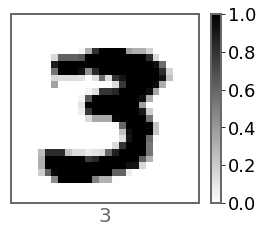

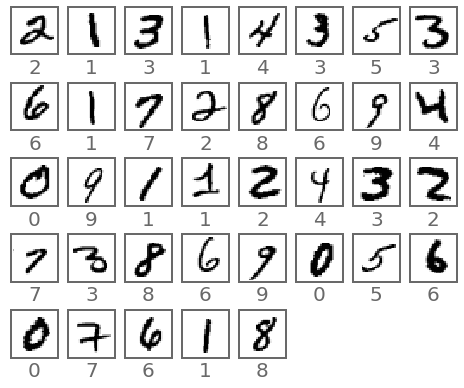

Train :   X shape=(60000, 784) type=float32  y shape=(60000,) type=int32
Test  :   X shape=(10000, 784) type=float32  y shape=(10000,) type=int32


In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()   # Cache dans ~/.keras/dataset/

X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test  = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)

X_train_size = X_train.shape[0]

ooo.plot_images(X_train.reshape(-1,28,28),y_train, [27],  x_size=5,y_size=5, colorbar=True,save_as="One-digits")
ooo.plot_images(X_train.reshape(-1,28,28),y_train, range(5,42), columns=8, save_as="Many-digits")

print('Train :   X shape={} type={}  y shape={} type={}'.format(X_train.shape,X_train.dtype,y_train.shape,y_train.dtype))
print('Test  :   X shape={} type={}  y shape={} type={}'.format(X_test.shape,X_test.dtype,y_test.shape,y_test.dtype))


In [5]:
%matplotlib tk
ooo.plot_image3d(X_train.reshape(-1,28,28)[27]*0.2, x_size=10,y_size=8)

In [6]:
%matplotlib inline

## Model construction
**Network** construction

In [7]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
    
with tf.name_scope("dnn"):
    op_hidden1 = tf.layers.dense(X,          n_hidden1, name="hidden1",   activation=tf.nn.relu)
    op_hidden2 = tf.layers.dense(op_hidden1, n_hidden2, name="hidden2",   activation=tf.nn.relu)
    op_output  = tf.layers.dense(op_hidden2, n_outputs, name="outputs",   activation=None)
    op_softmax = tf.nn.softmax(op_output)

**loss** function based on xentropy

In [8]:
with tf.name_scope("loss"):
    op_xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=op_output)
    op_loss = tf.reduce_mean(op_xentropy, name="loss")
#     op_loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=op_output)


**gradient descent** / optimizer

In [9]:
with tf.name_scope("train"):
    op_optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    op_training = op_optimizer.minimize(op_loss)

**Evaluation** and logs

In [10]:
with tf.name_scope("eval"):
    op_correct = tf.nn.in_top_k(op_output, y, 1)
    op_accuracy = tf.reduce_mean(tf.cast(op_correct, tf.float32))
    
op_acc_summary = tf.summary.scalar('ACC', op_accuracy)
file_writer = tf.summary.FileWriter(ooo.get_log_dir(), tf.get_default_graph())


log dir is         : ./run/lab-14.2.0/log/2019-09-16_11h11m35s
To run TensorBoard : # tensorboard --logdir="./run/lab-14.2.0/log"


**Initialization** and saver

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Model run

In [12]:

with tf.Session() as sess:

    # Initialisation
    init.run()
    i_batch=0
    stats_x_acc=[]
    stats_y_acc=[]
    k_batch = int( (X_train_size/batch_size)/log_by_epoch )

    # Pour chaqune époque
    for epoch in range(n_epochs):

        # Exécution des batchs
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            i_batch+=1
            
            # Training
            sess.run(op_training, feed_dict={X: X_batch, y: y_batch})

            # Logs
            if i_batch % k_batch == 0:
                step = i_batch*batch_size
                # ---- Matplotlib
                accuracy_test      = op_accuracy.eval(feed_dict={X: X_test[:1000], y: y_test[:1000]})
                stats_x_acc.append(step)
                stats_y_acc.append(accuracy_test)
                # ---- Tensorboard
                summary_str = op_acc_summary.eval(feed_dict={X: X_test[:1000], y: y_test[:1000]})
                file_writer.add_summary(summary_str, step)

        # Epoch evaluation
        accuracy_lastbatch = op_accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        accuracy_test      = op_accuracy.eval(feed_dict={X: X_test, y: y_test})
        loss               = op_loss.eval(    feed_dict={X: X_test, y: y_test})
        show_progress(epoch,accuracy_lastbatch, accuracy_test, loss)
        

    save_path = saver.save(sess, ooo.get_model_dir()+"/final.ckpt")
    print("\nModel saved.")



Epoch      Last batch acc.  Test acc.          Loss               Trained           

 000           0.9600           0.9051         0.3485               60 K
 001           0.9800           0.9229         0.2771              120 K
 002           0.9000           0.9320         0.2418              180 K
 003           0.9400           0.9410         0.2134              240 K
 004           1.0000           0.9452         0.1959              300 K
 005           0.9400           0.9482         0.1832              360 K
 006           0.9600           0.9508         0.1664              420 K
 007           1.0000           0.9552         0.1561              480 K
 008           0.9800           0.9570         0.1473              540 K
 009           0.9400           0.9592         0.1425              600 K
 010           1.0000           0.9617         0.1304              660 K
 011           0.9800           0.9634         0.1240              720 K
 012           0.9400           0.96

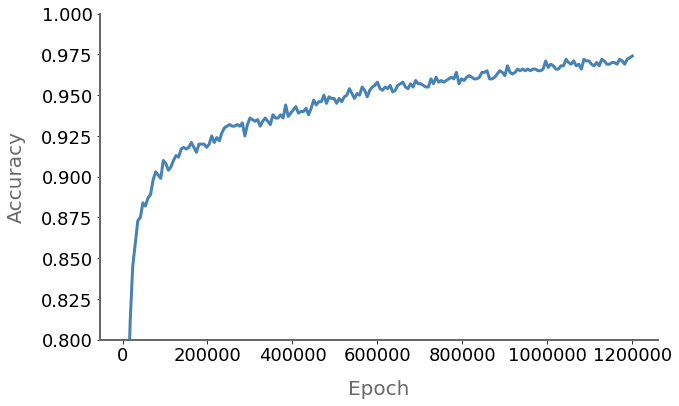

In [13]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)
axs.plot(stats_x_acc, stats_y_acc, "-")
axs.set_ylim(bottom=0.8,top=1)
axs.set_xlabel("Epoch", labelpad=15)
axs.set_ylabel("Accuracy",  labelpad=15)
ooo.save_fig("Accuracy")
plt.show()

## Model evaluation
Restore saved model  
Test it with a new dataset of 2000 images from test dataset

In [14]:
indices = np.random.randint(0,len(X_test),2000)

X_new = X_test[indices]
y_new = y_test[indices]

with tf.Session() as sess:
    
    print('\nRestore model...')
    saver.restore(sess, ooo.get_model_dir()+'/final.ckpt')
    
    print('\nStart prediction...')
    O = op_output.eval(feed_dict={X: X_new})
    S = op_softmax.eval(feed_dict={X: X_new})
    y_pred = np.argmax(O, axis=1)
    
    accuracy_new = op_accuracy.eval(feed_dict={X: X_new, y: y_new})
    print("\nAccuracy : {:7.4f}".format(accuracy_new))



Restore model...

Start prediction...

Accuracy :  0.9680


### Example of predictions


X[0]
   Output        :  -0.285    -4.682    -0.319    -1.026    -1.651     6.561     1.640    -2.753    -0.222    -5.498
   Softmax       :   0.001     0.000     0.001     0.001     0.000     0.989     0.007     0.000     0.001     0.000
   Classe        :  5, (5)

X[1]
   Output        :  -3.655    -8.469    -6.698     1.441     3.965    -2.985   -10.777     1.982    -0.015    10.128
   Softmax       :   0.000     0.000     0.000     0.000     0.002     0.000     0.000     0.000     0.000     0.997
   Classe        :  9, (9)

X[2]
   Output        :  -4.895     7.834     0.457    -2.569    -1.877    -3.560    -2.552     1.487    -0.268    -3.901
   Softmax       :   0.000     0.997     0.001     0.000     0.000     0.000     0.000     0.002     0.000     0.000
   Classe        :  1, (1)

X[3]
   Output        :  -3.295    -3.426    -4.237    -0.427     3.694    -4.261    -7.360    -0.111    -0.657    10.517
   Softmax       :   0.000     0.000     0.000     0.000     0.001     0.000

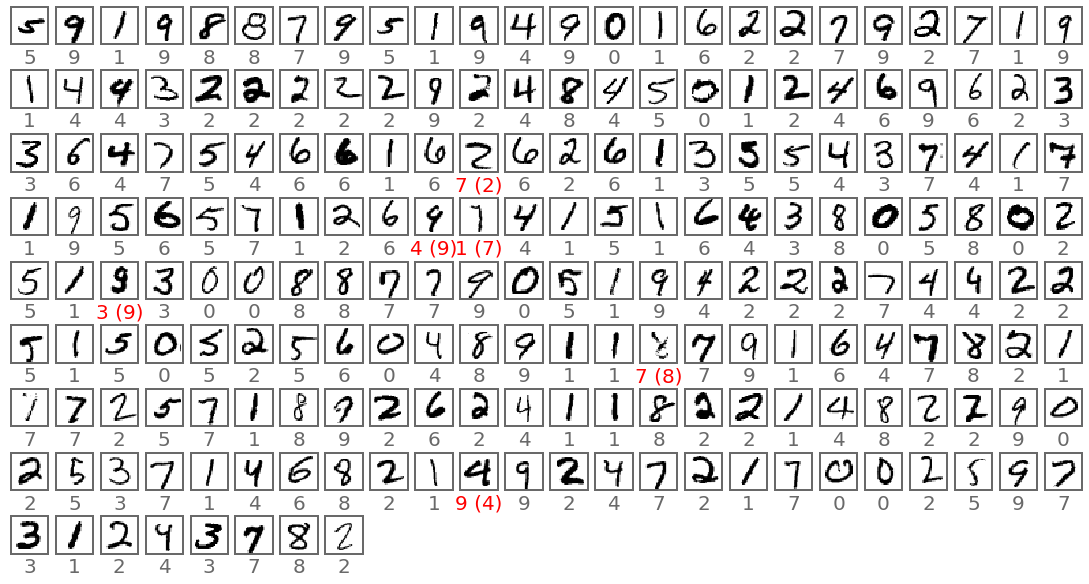

In [15]:
show_predictions(X_new,y_new,O,S,y_pred,range(6))
ooo.plot_images(X_new.reshape(-1,28,28), y_new, range(0,200), columns=24, save_as="Predictions", x_size=0.8, y_size=0.8, y_pred=y_pred)

### List of errors :

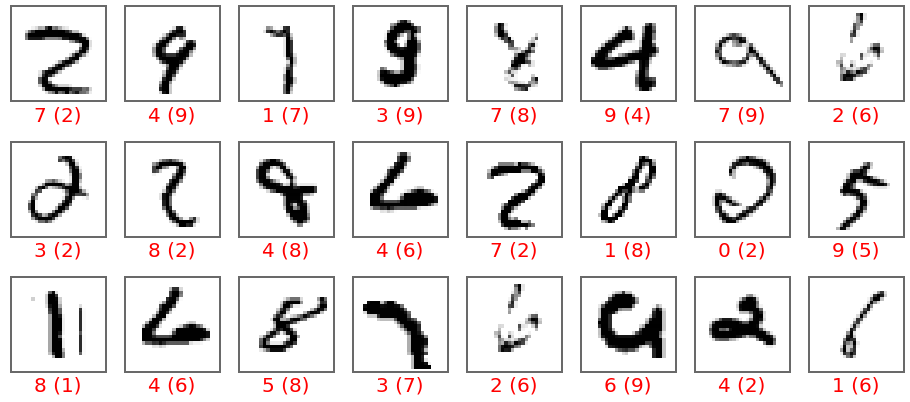

In [17]:
errors=[ i for i in range(len(X_new)) if y_pred[i]!=y_new[i] ]
errors=errors[:min(24,len(errors))]
ooo.plot_images(X_new.reshape(-1,28,28), y_new, errors, columns=8, save_as="Errors", x_size=2, y_size=2, y_pred=y_pred)